In [41]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import torch.nn.functional as F

dataset = np.load("nn_nnn_clusters_6.npz")

In [42]:
def get_graph(index, cutoff=2.5, box_size=10):

    positions = dataset['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(dataset['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)

In [43]:
def plot_graph(ax, graph, max_color_value = None, global_value = True):
    colormap = cm.viridis
    color_values = abs(graph.x)
    if max_color_value == None: 
        if color_values.max() != 0:
            color_values = color_values / color_values.max()
    else:
        color_values = color_values / max_color_value
    box_width, box_height = 0.4, 0.6
    box_offset = 0.6

    with torch.no_grad():
        # Plot the nodes:
        for idx, (pos, x) in enumerate(zip(graph.pos, graph.x)):
            x = round(float(x), 1)
            ax.scatter(pos[0], pos[1], color=colormap(color_values[idx]), edgecolor = "k", s=1000)
            ax.text(pos[0], pos[1], f'{x}', color='w', ha='center', va='center', fontsize = "12")    
            rect = plt.Rectangle((pos[0] + box_offset - box_width/2, pos[1] + box_offset - box_height / 2), box_width, box_height, edgecolor = "k", facecolor = "w")
            ax.add_patch(rect)
            ax.text(pos[0] + box_offset, pos[1] + box_offset, f'{idx}', color="k", ha="center", va="center")
        
        # Plot the edges:
        for idx, (i1,i2) in enumerate(graph.edge_index.T):
            ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)
            
    if global_value:
        ax.scatter([], [], label = f"{round(float(graph.y), 2)}")
        ax.legend(loc = "lower left")

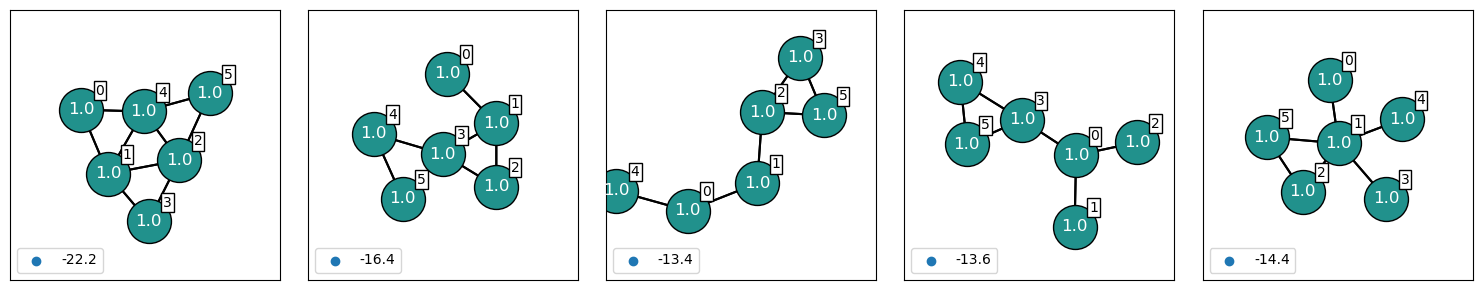

In [44]:
fig, axes = plt.subplots(1, 5, figsize = (15, 3))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = get_graph(10 * i)
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
       
    plot_graph(ax, graph, 2)
fig.tight_layout()

In [45]:
class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_message, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = torch.nn.Linear(d_in, d_message)
        self.phi = torch.nn.Linear(d_in + d_message, d_out)

    def forward(self, x, edge_index):    
        sum_psi_of_x_j = self.propagate(edge_index, x=x)
        x = self.phi(torch.cat([x, sum_psi_of_x_j], dim=1))
        return x

    def message(self, x_j):
        return self.psi(x_j)

class OneMessageGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, 1, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        return x

    def local_energies(self, graph):
        return self.representation(graph).flatten()
    
gnn_m1 = OneMessageGNN()
   

In [46]:
num_graphs = len(dataset['positions'])  # Number of graphs in the dataset
all_graphs = [get_graph(index) for index in range(num_graphs)]

loader = DataLoader(all_graphs[:-4], batch_size=10, shuffle=False)

In [47]:
optimizer = torch.optim.Adam(gnn_m1.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 500

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_m1(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/500, Loss: 1.1271
Epoch 100/500, Loss: 0.9767
Epoch 150/500, Loss: 0.8042
Epoch 200/500, Loss: 0.6328
Epoch 250/500, Loss: 0.4779
Epoch 300/500, Loss: 0.3485
Epoch 350/500, Loss: 0.2479
Epoch 400/500, Loss: 0.1749
Epoch 450/500, Loss: 0.1258
Epoch 500/500, Loss: 0.0951


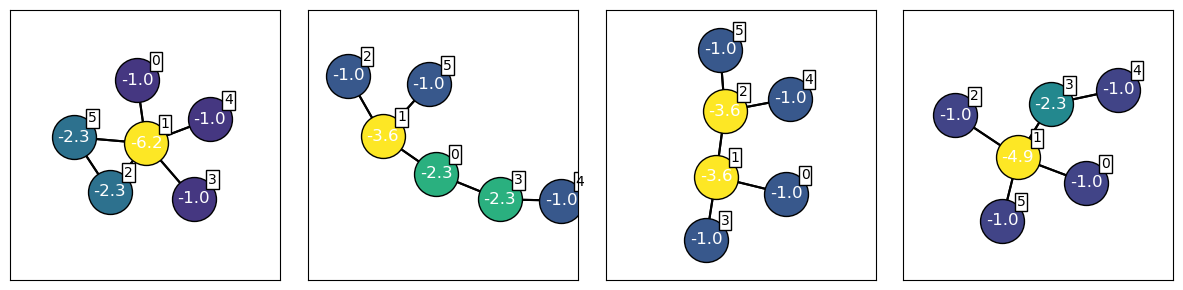

In [48]:
fig, axes = plt.subplots(1, 4, figsize = (12, 3))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = get_graph(num_graphs - 4 + i)
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
    graph.x = gnn_m1.local_energies(graph)   
    plot_graph(ax, graph, global_value=False)
fig.tight_layout()

[-22.200000762939453, -19.0, -22.200000762939453, -16.0, -18.799999237060547, -19.399999618530273, -19.0, -19.399999618530273, -19.200000762939453, -13.199999809265137, -16.399999618530273, -19.600000381469727, -22.0, -16.399999618530273, -16.200000762939453, -16.200000762939453, -19.0, -16.600000381469727, -16.399999618530273, -16.0, -13.399999618530273, -16.200000762939453, -16.399999618530273, -13.399999618530273, -16.600000381469727, -16.0, -13.600000381469727, -13.800000190734863, -13.800000190734863, -13.600000381469727, -13.600000381469727, -16.200000762939453, -10.800000190734863, -11.0, -16.799999237060547, -17.0, -13.399999618530273, -14.0, -13.600000381469727, -13.800000190734863, -14.399999618530273, -11.0, -11.199999809265137, -11.399999618530273] [-21.651477813720703, -19.027862548828125, -21.65147590637207, -16.404247283935547, -19.027860641479492, -19.027862548828125, -19.027862548828125, -19.027862548828125, -19.027862548828125, -13.780632019042969, -16.404247283935547

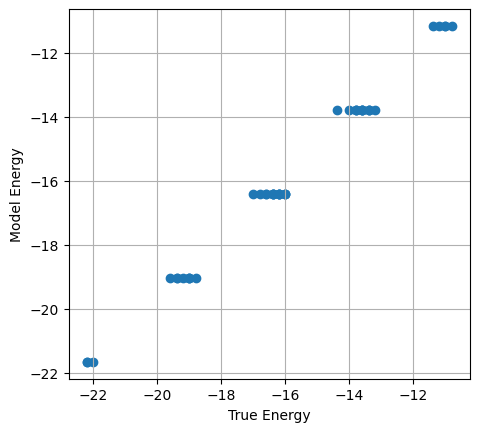

In [49]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in all_graphs]
model_energies = [gnn_m1(graph).detach() for graph in all_graphs]
# Convert true_energies to scalars
true_energies = [float(graph.y) for graph in all_graphs]

# Convert model_energies to scalars
model_energies = [float(gnn_m1(graph).detach().item()) for graph in all_graphs]

# Verify the data structure
print(true_energies, model_energies)

ax.scatter(true_energies, model_energies)


In [50]:
class TwoMessageGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, 1, 1)
        self.message_passing_2 = PhiPsiGNN(1, 1, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        x = self.message_passing_2(x, graph.edge_index)
        return x

    def local_energies(self, graph):
        return self.representation(graph).flatten()
    
gnn_m2 = TwoMessageGNN()

In [51]:
optimizer = torch.optim.Adam(gnn_m2.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_m2(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/1000, Loss: 0.8960
Epoch 100/1000, Loss: 0.1818
Epoch 150/1000, Loss: 0.0151
Epoch 200/1000, Loss: 0.0100
Epoch 250/1000, Loss: 0.0084
Epoch 300/1000, Loss: 0.0069
Epoch 350/1000, Loss: 0.0055
Epoch 400/1000, Loss: 0.0042
Epoch 450/1000, Loss: 0.0031
Epoch 500/1000, Loss: 0.0022
Epoch 550/1000, Loss: 0.0012
Epoch 600/1000, Loss: 0.0015
Epoch 650/1000, Loss: 0.0005
Epoch 700/1000, Loss: 0.0003
Epoch 750/1000, Loss: 0.0001
Epoch 800/1000, Loss: 0.0001
Epoch 850/1000, Loss: 0.0000
Epoch 900/1000, Loss: 0.0000
Epoch 950/1000, Loss: 0.0000
Epoch 1000/1000, Loss: 0.0000


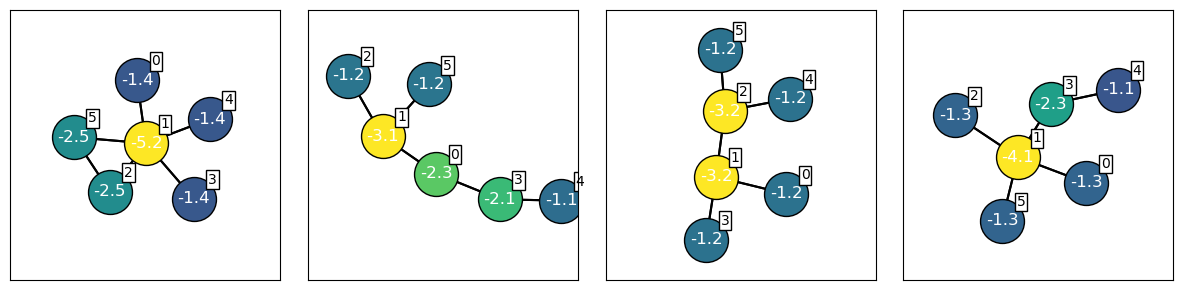

In [52]:
fig, axes = plt.subplots(1, 4, figsize = (12, 3))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = get_graph(num_graphs - 4 + i)
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
    graph.x = gnn_m2.local_energies(graph)   
    plot_graph(ax, graph, global_value=False)
fig.tight_layout()

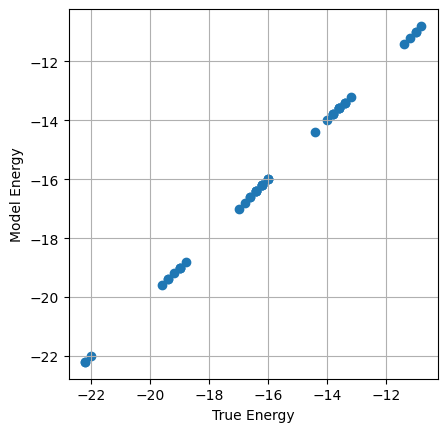

In [53]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [float(graph.y) for graph in all_graphs]
model_energies = [float(gnn_m2(graph).detach().item()) for graph in all_graphs]
ax.scatter(true_energies, model_energies)

In [54]:
MODIFIED = True
if MODIFIED:
    dataset = np.load('modified_tb_clusters_6.npz')
else:
    dataset = np.load('tight_binding_clusters_6.npz')

def get_graph(index, cutoff=2.5, box_size=10):

    positions = dataset['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(dataset['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)

In [55]:
num_graphs = len(dataset['positions'])
test_index = [23, 36, 21, 19, 9, 39, 42, 3, 0]
train_graphs = []
test_graphs = [None for _ in range(len(test_index))]
for i in range(num_graphs):
    if i in test_index:
        for j, index in enumerate(test_index):
            if index == i:
                test_graphs[j] = get_graph(i)
    else:
        train_graphs.append(get_graph(i))

loader = DataLoader(train_graphs, batch_size=10, shuffle=True)

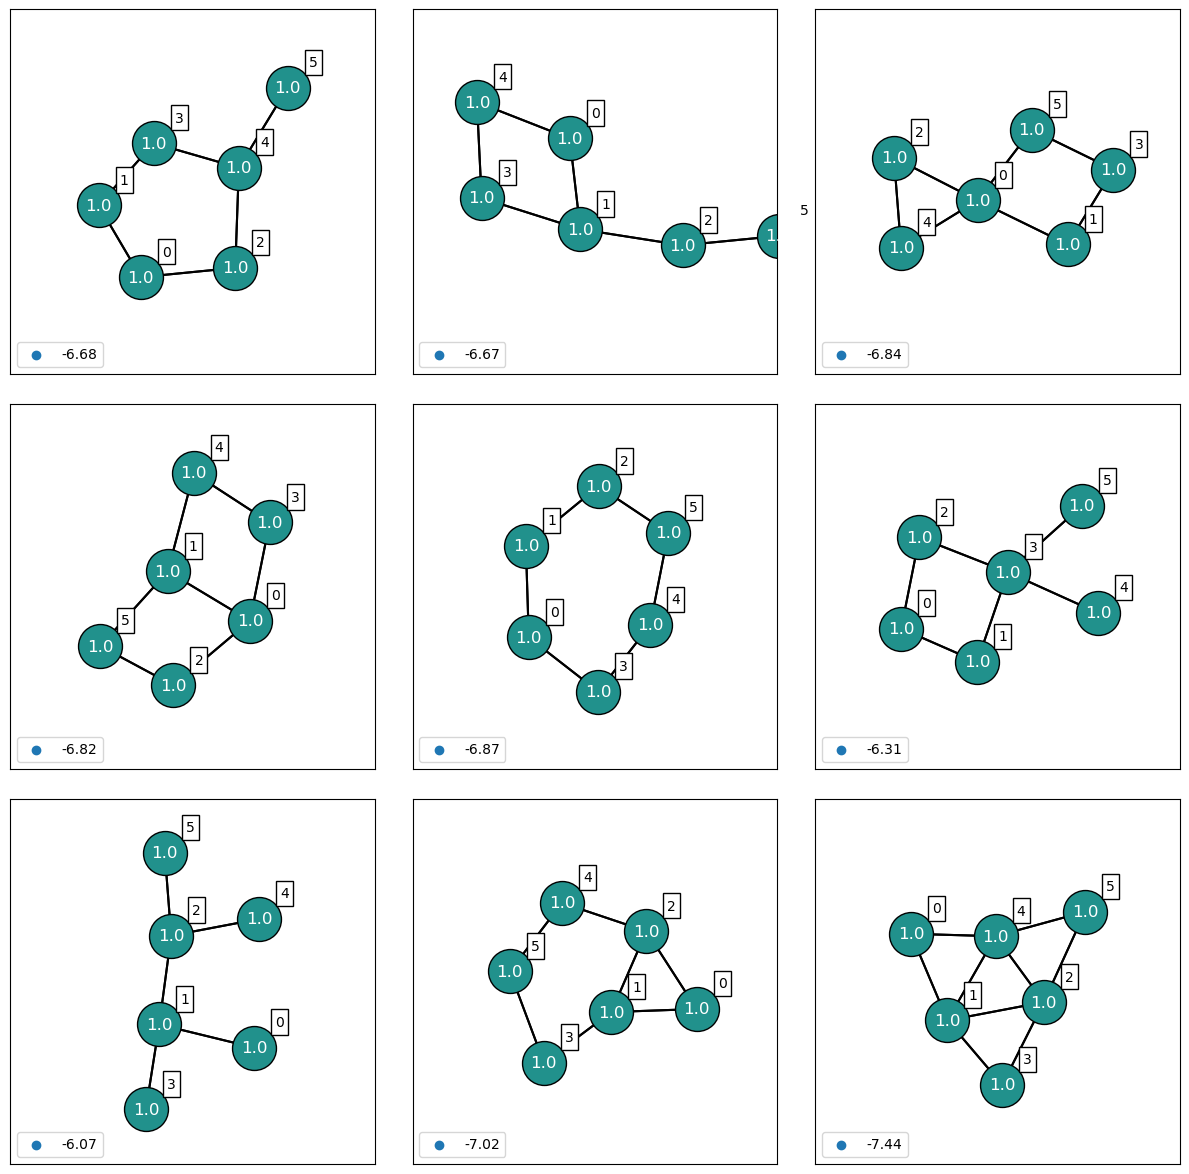

In [56]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = test_graphs[i]
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
   
    plot_graph(ax, graph, max_color_value=2, global_value=True)
fig.tight_layout()

In [57]:
class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [58]:
gnn_m2 = TwoMessageGNN()

optimizer = torch.optim.Adam(gnn_m2.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_m2(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/1000, Loss: 0.6293
Epoch 100/1000, Loss: 0.1395
Epoch 150/1000, Loss: 0.0402
Epoch 200/1000, Loss: 0.0274
Epoch 250/1000, Loss: 0.0276
Epoch 300/1000, Loss: 0.0255
Epoch 350/1000, Loss: 0.0266
Epoch 400/1000, Loss: 0.0327
Epoch 450/1000, Loss: 0.0252
Epoch 500/1000, Loss: 0.0238
Epoch 550/1000, Loss: 0.0224
Epoch 600/1000, Loss: 0.0230
Epoch 650/1000, Loss: 0.0237
Epoch 700/1000, Loss: 0.0229
Epoch 750/1000, Loss: 0.0226
Epoch 800/1000, Loss: 0.0268
Epoch 850/1000, Loss: 0.0227
Epoch 900/1000, Loss: 0.0205
Epoch 950/1000, Loss: 0.0222
Epoch 1000/1000, Loss: 0.0253


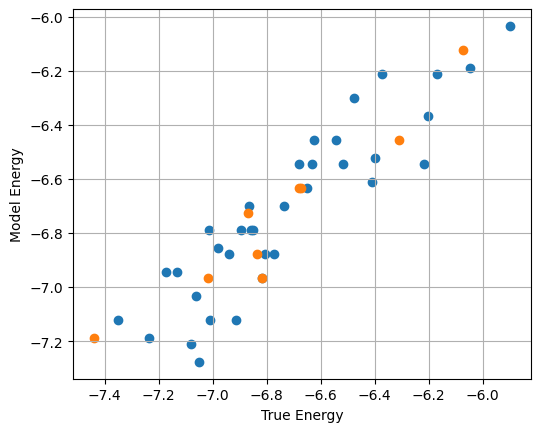

In [59]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in train_graphs]
model_energies = [torch.sum(gnn_m2.local_energies(graph)).detach() for graph in train_graphs]
ax.scatter(true_energies, model_energies)
true_energies = [graph.y for graph in test_graphs]
model_energies = [torch.sum(gnn_m2.local_energies(graph)).detach() for graph in test_graphs]
ax.scatter(true_energies, model_energies)

In [60]:
class FourMessageGNN(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1, mes2=1, hid2=1, mes3=1, hid3=1, mes4=1):
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, mes1, hid1)
        self.message_passing_2 = PhiPsiGNN(hid1, mes2, hid2)
        self.message_passing_3 = PhiPsiGNN(hid2, mes3, hid3)
        self.message_passing_4 = PhiPsiGNN(hid3, mes4, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        x = self.message_passing_2(x, graph.edge_index)
        x = self.message_passing_3(x, graph.edge_index)
        x = self.message_passing_4(x, graph.edge_index)
        return x

    def local_energies(self, graph):
        return self.representation(graph).flatten()

In [61]:
gnn_m4 = FourMessageGNN(mes1=4, hid1=4, mes2=4, hid2=4, mes3=4, hid3=4, mes4=4)

optimizer = torch.optim.Adam(gnn_m4.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_m4(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/1000, Loss: 0.0529
Epoch 100/1000, Loss: 0.0347
Epoch 150/1000, Loss: 0.0286
Epoch 200/1000, Loss: 0.0228
Epoch 250/1000, Loss: 0.0242
Epoch 300/1000, Loss: 0.0187
Epoch 350/1000, Loss: 0.0210
Epoch 400/1000, Loss: 0.0277
Epoch 450/1000, Loss: 0.0224
Epoch 500/1000, Loss: 0.0192
Epoch 550/1000, Loss: 0.0276
Epoch 600/1000, Loss: 0.0191
Epoch 650/1000, Loss: 0.0205
Epoch 700/1000, Loss: 0.0254
Epoch 750/1000, Loss: 0.0191
Epoch 800/1000, Loss: 0.0233
Epoch 850/1000, Loss: 0.0183
Epoch 900/1000, Loss: 0.0211
Epoch 950/1000, Loss: 0.0249
Epoch 1000/1000, Loss: 0.0201


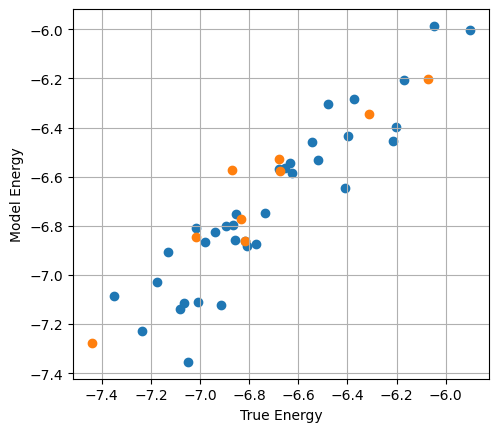

In [62]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in train_graphs]
model_energies = [torch.sum(gnn_m4.local_energies(graph)).detach() for graph in train_graphs]
ax.scatter(true_energies, model_energies)
true_energies = [graph.y for graph in test_graphs]
model_energies = [torch.sum(gnn_m4.local_energies(graph)).detach() for graph in test_graphs]
ax.scatter(true_energies, model_energies)

In [63]:
class ActivatedFourMessageGNN(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1, mes2=1, hid2=1, mes3=1, hid3=1, mes4=1):
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, mes1, hid1)
        self.message_passing_2 = PhiPsiGNN(hid1, mes2, hid2)
        self.message_passing_3 = PhiPsiGNN(hid2, mes3, hid3)
        self.message_passing_4 = PhiPsiGNN(hid3, mes4, 1)    
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP1 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_2(x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP2 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_3(x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP3 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_4(x, graph.edge_index)
        #print("Raw MP4 output - mean:", x.mean().item(), "std:", x.std().item(),
        #"min:", x.min().item(), "max:", x.max().item())
        x = F.leaky_relu(x)
        #print("MP4 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        return x

    def local_energies(self, graph):
        return self.representation(graph).flatten()

In [64]:
gnn_act_m4 = ActivatedFourMessageGNN(mes1=4, hid1=4, mes2=4, hid2=4, mes3=4, hid3=4, mes4=4)

optimizer = torch.optim.Adam(gnn_act_m4.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_act_m4(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/1000, Loss: 2.8020
Epoch 100/1000, Loss: 0.1950
Epoch 150/1000, Loss: 0.1650
Epoch 200/1000, Loss: 0.1951
Epoch 250/1000, Loss: 0.1147
Epoch 300/1000, Loss: 0.1215
Epoch 350/1000, Loss: 0.1142
Epoch 400/1000, Loss: 0.1518
Epoch 450/1000, Loss: 0.0660
Epoch 500/1000, Loss: 0.0789
Epoch 550/1000, Loss: 0.0848
Epoch 600/1000, Loss: 0.0407
Epoch 650/1000, Loss: 0.0605
Epoch 700/1000, Loss: 0.0439
Epoch 750/1000, Loss: 0.0471
Epoch 800/1000, Loss: 0.0290
Epoch 850/1000, Loss: 0.0280
Epoch 900/1000, Loss: 0.0481
Epoch 950/1000, Loss: 0.0269
Epoch 1000/1000, Loss: 0.0265


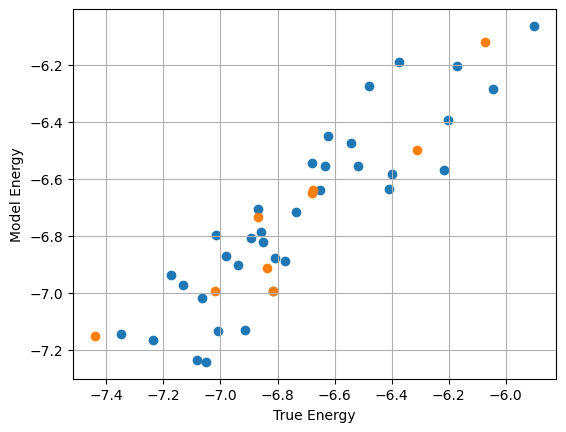

In [65]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in train_graphs]
model_energies = [torch.sum(gnn_act_m4.local_energies(graph)).detach() for graph in train_graphs]
ax.scatter(true_energies, model_energies)
true_energies = [graph.y for graph in test_graphs]
model_energies = [torch.sum(gnn_act_m4.local_energies(graph)).detach() for graph in test_graphs]
ax.scatter(true_energies, model_energies)

In [66]:
class ActivatedHeaderFourMessageGNN(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1, mes2=1, hid2=1, mes3=1, hid3=1, mes4=1, hid4=1):
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, mes1, hid1)
        self.message_passing_2 = PhiPsiGNN(hid1, mes2, hid2)
        self.message_passing_3 = PhiPsiGNN(hid2, mes3, hid3)
        self.message_passing_4 = PhiPsiGNN(hid3, mes4, hid4)
        self.header = torch.nn.Linear(hid4, 1)    
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP1 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_2(x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP2 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_3(x, graph.edge_index)
        x = F.leaky_relu(x)
        #print("MP3 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.message_passing_4(x, graph.edge_index)
        #print("Raw MP4 output - mean:", x.mean().item(), "std:", x.std().item(),
        #"min:", x.min().item(), "max:", x.max().item())
        x = F.leaky_relu(x)
        #print("MP4 output - mean:", x.mean().item(), "std:", x.std().item(), "min:", x.min().item(), "max:", x.max().item())
        x = self.header(x)
        return x

    def local_energies(self, graph):
        return self.representation(graph).flatten()

In [67]:
gnn_act_header_m4 = ActivatedHeaderFourMessageGNN(mes1=4, hid1=4, mes2=4, hid2=4, mes3=4, hid3=4, mes4=4, hid4=8)

optimizer = torch.optim.Adam(gnn_act_header_m4.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_act_header_m4(graphs)
        N = len(output)
        total_N += N
        loss = loss_fn(output.flatten(), graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 50/1000, Loss: 0.0313
Epoch 100/1000, Loss: 0.0298
Epoch 150/1000, Loss: 0.0252
Epoch 200/1000, Loss: 0.0174
Epoch 250/1000, Loss: 0.0108
Epoch 300/1000, Loss: 0.0183
Epoch 350/1000, Loss: 0.0089
Epoch 400/1000, Loss: 0.0086
Epoch 450/1000, Loss: 0.0174
Epoch 500/1000, Loss: 0.0092
Epoch 550/1000, Loss: 0.0115
Epoch 600/1000, Loss: 0.0034
Epoch 650/1000, Loss: 0.0055
Epoch 700/1000, Loss: 0.0080
Epoch 750/1000, Loss: 0.0197
Epoch 800/1000, Loss: 0.0027
Epoch 850/1000, Loss: 0.0074
Epoch 900/1000, Loss: 0.0058
Epoch 950/1000, Loss: 0.0035
Epoch 1000/1000, Loss: 0.0029


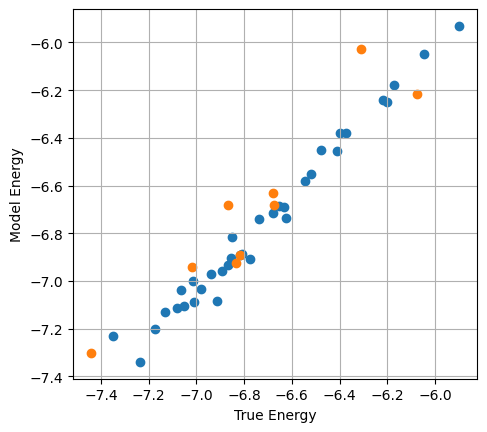

In [68]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in train_graphs]
model_energies = [torch.sum(gnn_act_header_m4.local_energies(graph)).detach() for graph in train_graphs]
ax.scatter(true_energies, model_energies)
true_energies = [graph.y for graph in test_graphs]
model_energies = [torch.sum(gnn_act_header_m4.local_energies(graph)).detach() for graph in test_graphs]
ax.scatter(true_energies, model_energies)

In [69]:
class ActivatedHeader2FourMessageGNN(torch.nn.Module):
    def __init__(self, mes1=1, hid1=1, mes2=1, hid2=1, mes3=1, hid3=1, mes4=1, hid4=1):
        super().__init__()
        super().__init__()
        self.message_passing_1 = PhiPsiGNN(1, mes1, hid1)
        self.message_passing_2 = PhiPsiGNN(hid1, mes2, hid2)
        self.message_passing_3 = PhiPsiGNN(hid2, mes3, hid3)
        self.message_passing_4 = PhiPsiGNN(hid3, mes4, hid4)
        self.header1 = torch.nn.Linear(hid4, hid4)    
        self.header2 = torch.nn.Linear(hid4, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = self.aggr(x, graph.batch)
        return x.flatten()
    
    def representation(self, graph):
        x = self.message_passing_1(graph.x, graph.edge_index)
        x = F.silu(x)
        x = self.message_passing_2(x, graph.edge_index)
        x = F.silu(x)
        x = self.message_passing_3(x, graph.edge_index)
        x = F.silu(x)
        x = self.message_passing_4(x, graph.edge_index)
        x = F.silu(self.header1(x))
        return self.header2(x)

    def local_energies(self, graph):
        x = self.representation(graph)
        return x
        

In [70]:
gnn_act_header2_m4 = ActivatedHeader2FourMessageGNN(mes1=4, hid1=4, mes2=4, hid2=4, mes3=4, hid3=4, mes4=4, hid4=4)

optimizer = torch.optim.Adam(gnn_act_header2_m4.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    
    for graphs in loader:
        optimizer.zero_grad()

        output = gnn_act_header2_m4(graphs)
        #print(f"Output: {output.shape}")
        #print(f"Target: {graphs.y.shape}")
        N = len(output)
        total_N += N
        loss = loss_fn(output, graphs.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 50/1000, Loss: 0.0328
Epoch 100/1000, Loss: 0.0296
Epoch 150/1000, Loss: 0.0282
Epoch 200/1000, Loss: 0.0280
Epoch 250/1000, Loss: 0.0231
Epoch 300/1000, Loss: 0.0224
Epoch 350/1000, Loss: 0.0177
Epoch 400/1000, Loss: 0.0193
Epoch 450/1000, Loss: 0.0128
Epoch 500/1000, Loss: 0.0125
Epoch 550/1000, Loss: 0.0165
Epoch 600/1000, Loss: 0.0112
Epoch 650/1000, Loss: 0.0099
Epoch 700/1000, Loss: 0.0164
Epoch 750/1000, Loss: 0.0053
Epoch 800/1000, Loss: 0.0151
Epoch 850/1000, Loss: 0.0048
Epoch 900/1000, Loss: 0.0056
Epoch 950/1000, Loss: 0.0053
Epoch 1000/1000, Loss: 0.0087


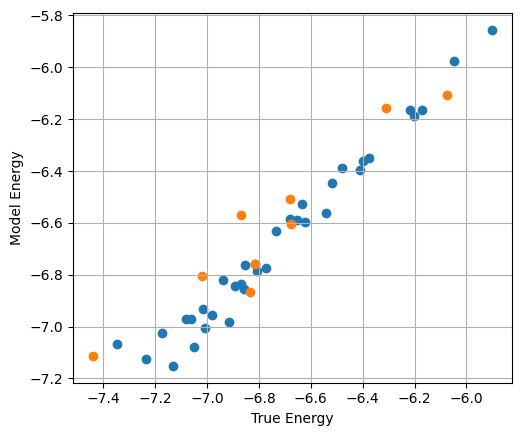

In [71]:
fig, ax = plt.subplots()
ax.grid()
ax.set_aspect("equal")
ax.set_xlabel("True Energy")
ax.set_ylabel("Model Energy")

true_energies = [graph.y for graph in train_graphs]
model_energies = [torch.sum(gnn_act_header2_m4.local_energies(graph)).detach() for graph in train_graphs]
ax.scatter(true_energies, model_energies)
true_energies = [graph.y for graph in test_graphs]
model_energies = [torch.sum(gnn_act_header2_m4.local_energies(graph)).detach() for graph in test_graphs]
ax.scatter(true_energies, model_energies)

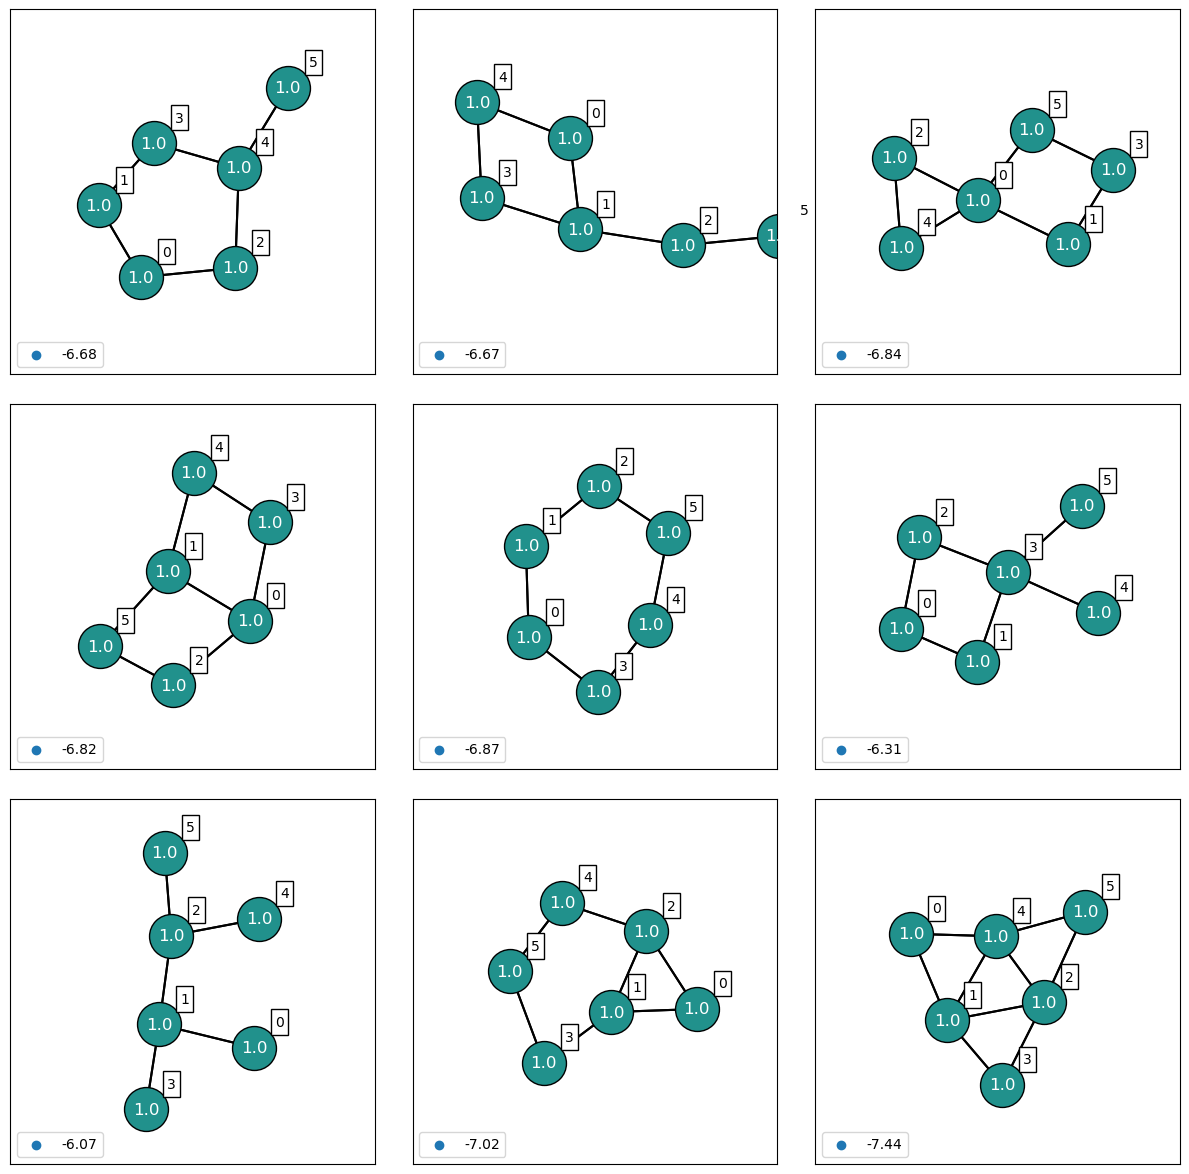

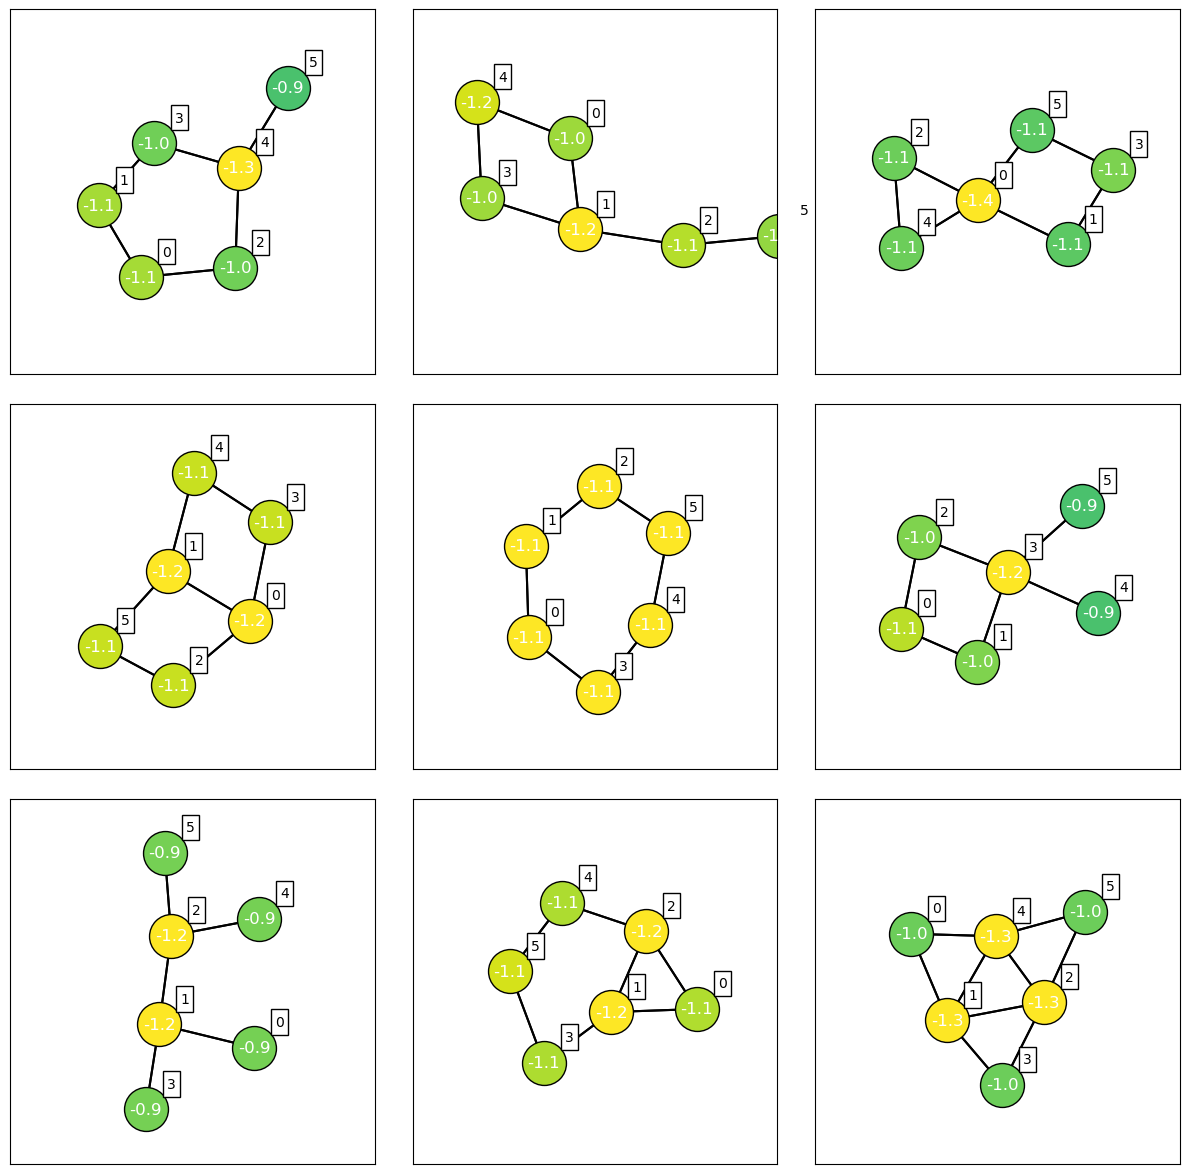

In [73]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = test_graphs[i]
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
   
    plot_graph(ax, graph, max_color_value=2, global_value=True)
fig.tight_layout()


#now plot the graphs with model energies
fig, axes = plt.subplots(3, 3, figsize = (12, 12))

padding = 1.3
largest_x_range = max([graph.pos[:, 0].max() - graph.pos[:, 0].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_y_range = max([graph.pos[:, 1].max() - graph.pos[:, 1].min() for graph in [get_graph(10 * i) for i in range(5)]])
largest_range = max(largest_x_range, largest_y_range)

for i, ax in enumerate(axes.ravel()):
    graph = test_graphs[i]
    ax.set_xlim(torch.mean(graph.pos[:, 0]) - largest_range * padding / 2, torch.mean(graph.pos[:, 0]) + largest_range * padding / 2)
    ax.set_ylim(torch.mean(graph.pos[:, 1]) - largest_range * padding / 2, torch.mean(graph.pos[:, 1]) + largest_range * padding / 2) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
    graph.x = gnn_act_header2_m4.local_energies(graph)   
    plot_graph(ax, graph, global_value=False)
fig.tight_layout()


